In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix


# Initialization

In [41]:
train_data = pd.read_csv('uncleaned_data.tsv', sep = '\t')

In [42]:
train_data = train_data[['Uniq Id', 'Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags' ]]


In [43]:
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [44]:
# Filling missing values in data frame
train_data.fillna({'Product Rating' : 0}, inplace = True)
train_data.fillna({'Product Reviews Count' : 0}, inplace = True)
train_data.fillna({'Product Category' : ''}, inplace = True)
train_data.fillna({'Product Brand' : ''}, inplace = True)
train_data.fillna({'Product Description' : 0}, inplace = True)


In [45]:
column_name_mapping = {
    'Uniq Id':'ID',
    'Product Id' : 'ProdID',
    'Product Rating' : 'Rating',
    'Product Reviews Count' : 'ReviewCount',
    'Product Category' : 'Category',
    'Product Brand' : 'Brand',
    'Product Name' : 'Name',
    'Product Image Url' : 'ImageURL',
    'Product Description' : 'Description',
    'Product Tags' : 'Tags',
    'Product Contents' : 'Contents'

}

In [46]:
train_data.rename(columns=column_name_mapping, inplace=True)

In [47]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)




# Statistics 

In [65]:
number_users = train_data['ID'].nunique()
number_items = train_data['ProdID'].nunique()
number_ratings = train_data['Rating'].nunique()
print (f"Unique users : {number_users}")
print (f"Unique items : {number_items}")
print (f"Unique ratings : {number_ratings}")
train_data


Unique users : 1721
Unique items : 1697
Unique ratings : 36


,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags,tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",Category Premium Beauty > Premium Makeup...
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi...",Category Beauty > Hair Care > Hair Color...
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...,Category Beauty > Hair Care > Hair Color...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ...",Category Bea...
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit...",Category Seasonal > Stock Up Essentials ...
...,...,...,...,...,...,...,...,...,...,...,...
4995,2.771000e+03,208.0,4.5,2.0,Household Essentials > Air Fresheners > Spray ...,Eclectic Lady,"Garden Mint Room Spray (Double Strength), 4 ou...",https://i5.walmartimages.com/asr/0e0416ae-6b70...,"Garden Mint is a lovely blend of spearmint, le...","Garden Mint Room Spray (Double Strength), 4 ou...",Category Household Essentials > Air Fres...
4996,0.000000e+00,1.0,3.9,7484.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,https://i5.walmartimages.com/asr/24d7a837-51f8...,Garnier Nutrisse Nourishing Hair Color Creme B...,Garnier Nutrisse Nourishing Hair Color Creme (...,Category Beauty > Hair Care > Hair Color...
4997,3.400000e+01,96.0,0.0,4.0,Beauty > Makeup > Nails,Stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",https://i5.walmartimages.com/asr/d6202179-2c93...,Multifunctional : Our nail drill kit come with...,"Nail File Electric Drill, 6 in 1 Professional ...",Category Beaut...
4998,9.000000e+00,7.0,0.0,0.0,Premium Beauty > Premium Bath & Body > Premium...,Creed,Creed Love In Black Hair And Body Wash 6.8oz/2...,https://i5.walmartimages.com/asr/3dc99239-66d2...,0,Creed Love In Black Hair And Body Wash 6.8oz/2...,Category Premium Beauty > Premium Bath &...


## Heatmap

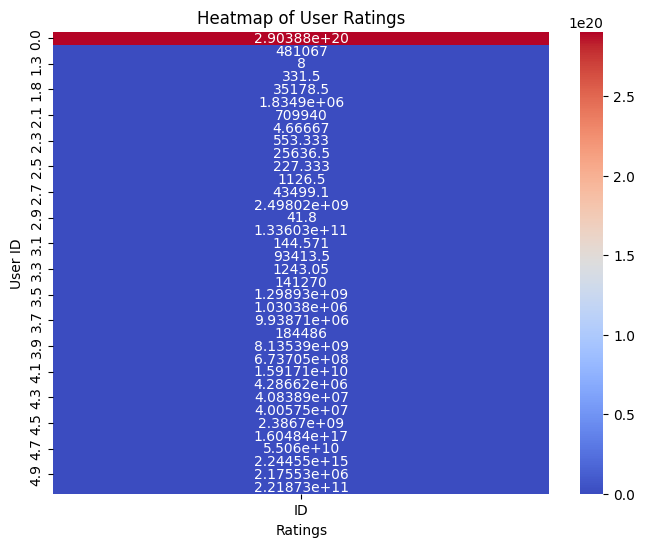

In [63]:
heatmap_data = train_data.pivot_table('ID', 'Rating')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap = 'coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

## Distribution of Interactions

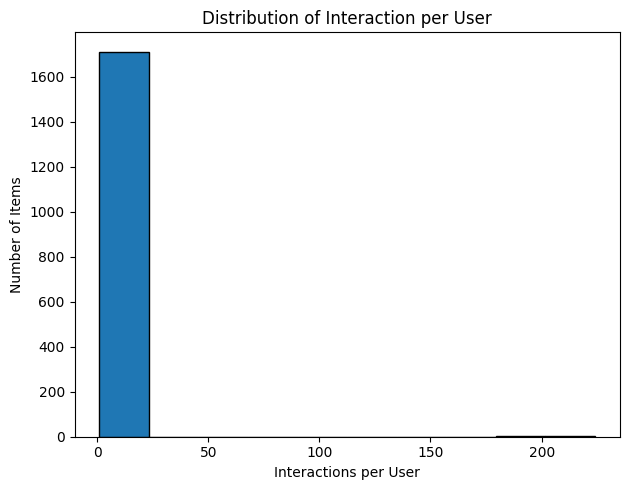

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags,tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",Category Premium Beauty > Premium Makeup...
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi...",Category Beauty > Hair Care > Hair Color...
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...,Category Beauty > Hair Care > Hair Color...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ...",Category Bea...
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit...",Category Seasonal > Stock Up Essentials ...
...,...,...,...,...,...,...,...,...,...,...,...
4995,2.771000e+03,208.0,4.5,2.0,Household Essentials > Air Fresheners > Spray ...,Eclectic Lady,"Garden Mint Room Spray (Double Strength), 4 ou...",https://i5.walmartimages.com/asr/0e0416ae-6b70...,"Garden Mint is a lovely blend of spearmint, le...","Garden Mint Room Spray (Double Strength), 4 ou...",Category Household Essentials > Air Fres...
4996,0.000000e+00,1.0,3.9,7484.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,https://i5.walmartimages.com/asr/24d7a837-51f8...,Garnier Nutrisse Nourishing Hair Color Creme B...,Garnier Nutrisse Nourishing Hair Color Creme (...,Category Beauty > Hair Care > Hair Color...
4997,3.400000e+01,96.0,0.0,4.0,Beauty > Makeup > Nails,Stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",https://i5.walmartimages.com/asr/d6202179-2c93...,Multifunctional : Our nail drill kit come with...,"Nail File Electric Drill, 6 in 1 Professional ...",Category Beaut...
4998,9.000000e+00,7.0,0.0,0.0,Premium Beauty > Premium Bath & Body > Premium...,Creed,Creed Love In Black Hair And Body Wash 6.8oz/2...,https://i5.walmartimages.com/asr/3dc99239-66d2...,0,Creed Love In Black Hair And Body Wash 6.8oz/2...,Category Premium Beauty > Premium Bath &...


In [64]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
train_data['ID'].value_counts().plot(kind='hist', bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Items')
plt.title('Distribution of Interaction per User')

plt.tight_layout()
plt.show()

train_data


# Cleaning

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm") # loads small english langauge model

def clean_and_extract_tags(text):
    if isinstance(text, int):
        return
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS ]
    return ','.join(tags)

tag_extract_columns = ['Category', 'Brand', 'Description']

for each in tag_extract_columns:
    train_data[each] = train_data[each].apply(clean_and_extract_tags)







## Tags column made

In [ ]:
train_data['tags'] = train_data[tag_extract_columns].apply(lambda row: ''.join(str(row)), axis=1)

# Rating Based Recommendation System

This recommendation system is used when a user has recently signed up and we have no history of the user.

In [ ]:
average_ratings = train_data.groupby(['Name', 'ReviewCount', 'Brand', 'ImageURL'])['Rating'].mean().reset_index()

top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_based_recomm = top_rated_items.head(10)


# Content Based Recommendation System

This system recommends products to user based on attributes or features of items and preference of user.